# [**QiVC-Net: Quantum-Inspired Variational Convolutional Network, with Application to Biosignal Classification**](https://arxiv.org/abs/2506.xxxxx)  

**Preprint:** [arXiv:2506.xxxxx](https://arxiv.org/abs/2506.xxxxx)  

---

**Amin Golnari**, **Jamileh Yousefi**, **Reza Moheimani**, **Saeid Sanei**. **"QiVC-Net: Quantum-Inspired Variational Convolutional Network, with Application to Biosignal Classification"**  
Preprint: [https://arxiv.org/abs/2506.xxxxx](https://arxiv.org/abs/2506.xxxxx)

**Amin Golnari**<sup>a</sup>, **Jamileh Yousefi**<sup>b</sup>, **Reza Moheimani**<sup>a</sup>, **Saeid Sanei**<sup>c,d</sup>  
<sup>a</sup> Faculty of Computer Science, Chemnitz University of Technology, Chemnitz, Germany  
<sup>b</sup> Shannon School of Business, Cape Breton University, Sydney, NS, Canada  
<sup>c</sup> Department of Electrical and Electronic Engineering, Imperial College London, London, UK  
<sup>d</sup> College of Engineering and Computer Science, VinUniversity, Hanoi, Vietnam  

**Link to the preprint version:** [Click here](https://arxiv.org/abs/2506.xxxxx)

**Run this implementation on Google Colab (coming soon):**  
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/amingolnari/Demo-QiVC-Net/blob/main/QiVC-Net.ipynb)

**Compatibility:**
- TensorFlow: 2.19.0  
- Keras: 3.10.0  
- Python: ≥ 3.12

---

## **Framework Overview**

**QiVC-Net** introduces the **Quantum-inspired Variational Convolution (QiVC)** framework, a novel learning paradigm that integrates probabilistic inference, variational optimization, and quantum-inspired transformations into convolutional neural networks.

The core innovation is the **Quantum-inspired Rotated Ensemble (QiRE)** mechanism, which applies differentiable, low-dimensional subspace rotations to convolutional weights, inspired by unitary evolution in quantum systems. This enables **structured, geometry-preserving uncertainty modeling** without adding learnable parameters. The framework is instantiated for **phonocardiogram (PCG) signal classification**, a challenging task marked by noise, inter-subject variability, and class imbalance.

QiVC-Net also features a **Reversal Fusion Residual (RFR)** block that captures bidirectional temporal dynamics by processing both forward and time-reversed inputs, enhancing robustness and temporal coherence.

---

## **Key Features:**

1. **QiVConv Layer**:  
   - A probabilistic convolutional layer that performs norm-preserving subspace rotations of kernel weights.
   - Enables expressive uncertainty-aware representations while maintaining parameter efficiency.

2. **Quantum-Inspired Rotated Ensemble (QiRE)**:  
   - Injects structured stochasticity via unitary-inspired rotations in a learnable low-dimensional subspace (*k = 5*).
   - Preserves weight-space geometry and avoids the instability of isotropic Gaussian noise.

3. **Uncertainty-Aware Dual-Path Architecture (RFR Block)**:  
   - Processes input signals in both forward and reversed temporal directions.
   - Fuses features via LSTM layers and residual refinement for robust temporal modeling.

4. **Robust PCG Classification**:  
   - Evaluated on **PhysioNet/CinC 2016** and **CirCor DigiScope 2022** datasets.
   - Achieves **97.84%** and **97.89%** average accuracy, respectively, with strong calibration (low ECE) and noise robustness.

5. **Clinically Aligned Design**:  
   - Lightweight, interpretable, and efficient, suitable for deployment in safety-critical applications.
   - Uses a **composite loss (CCE + Dice)** with dynamic weighting to handle class imbalance.

---

## **Usage of QiVConv in Practice**

The **QiVConv layer** can be used as a drop-in replacement for standard 1D convolutional layers in any TensorFlow/Keras model. It introduces no additional parameters, only learnable mean and standard deviation per weight (via the reparameterization trick), and supports end-to-end training with standard optimizers. It is particularly well-suited for **time-series and biosignal tasks** where uncertainty quantification, robustness to noise, and temporal symmetry are critical.

---

If our work is helpful to you, please kindly cite our paper as:

```bibtex
@article{golnari2025qivc,
  title={QiVC-Net: Quantum-Inspired Variational Convolutional Network, with Application to Biosignal Classification},
  author={Golnari, Amin and Yousefi, Jamileh and Moheimani, Reza and Sanei, Saeid},
  journal={arXiv preprint arXiv:2506.xxxxx},
  year={2025}
}
```

### Import required libraries and modules for deep learning, signal processing, and dataset handling

In [1]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 5.0 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, Input, Model
from tensorflow.keras.datasets import imdb, mnist

import medmnist
from medmnist import INFO, Evaluator

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

plt.style.use('seaborn-v0_8-whitegrid')

### Define the QiVConv1D layer: a quantum-inspired variational 1D convolutional layer that injects structured, geometry-preserving uncertainty via the QiRE (Quantum-inspired Rotated Ensemble) mechanism while remaining fully compatible with Keras

In [3]:
class QiVConv1D(tf.keras.layers.Layer):
    """
    Quantum-inspired Variational Convolution 1D (QiVConv1D) layer.

    This layer introduces structured, geometry-preserving uncertainty into 1D convolutional kernels
    via the Quantum-inspired Rotated Ensemble (QiRE) mechanism. Instead of isotropic Gaussian noise,
    QiRE applies differentiable, low-dimensional subspace rotations to the vectorized kernel weights,
    inspired by unitary evolution in quantum systems. This preserves norm and inter-parameter correlations,
    leading to more expressive and calibrated uncertainty-aware representations—without adding extra learnable parameters.

    During training, kernel weights are sampled as: W = μ + σ ⊙ ε_QiRE,
    where ε_QiRE is a structured noise vector generated through:
      1. Amplitude normalization of Gaussian noise,
      2. Projection into a random k-dimensional subspace (via QR decomposition),
      3. Unitary rotation within that subspace,
      4. Optional depolarizing noise (simulating decoherence).

    A KL divergence loss between the variational posterior and a Gaussian prior is automatically added
    to the model's total loss (scaled by `kl_weight`).

    At inference (training=False), deterministic forward pass uses the mean weights (μ).

    Designed for robust, uncertainty-aware modeling in time-series and biosignal tasks (e.g., PCG classification).
    Fully compatible with Keras and supports serialization.
    """
    def __init__(self, filters, kernel_size, strides=1, padding='same',
                 use_bias=True, init_std=1e-2, kl_weight=1e-4,
                 activation=None, qire_k=5, p_depol=0.0, **kwargs):
        super().__init__(**kwargs)
        # Standard Conv1D parameters
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper() # Ensure padding is uppercase for tf.nn.conv1d
        self.use_bias = use_bias
        self.activation = tf.keras.activations.get(activation)

        # Variational Bayes (Bayesian Neural Network) parameters
        self.init_std = init_std  # Initial standard deviation for the posterior
        self.kl_weight = kl_weight # KL divergence loss weight

        # QiRE (Quantum-inspired Rotated Ensemble) parameters
        self.qire_k = qire_k    # Dimension of the random subspace for rotation
        self.p_depol = p_depol  # Probability of depolarizing noise (simulating decoherence)

    def build(self, input_shape):
        in_channels = input_shape[-1]
        kernel_shape = (self.kernel_size, in_channels, self.filters)
        # Initialize the 'rho' parameter, which is used to calculate standard deviation: sigma = softplus(rho).
        # We solve for rho such that softplus(rho) = init_std, so rho = log(exp(init_std) - 1).
        rho_init_val = np.log(np.expm1(self.init_std))

        # Mean (mu) parameter for the kernel, initialized with Glorot Uniform
        self.kernel_mu = self.add_weight(
            name="kernel_mu", shape=kernel_shape,
            initializer="glorot_uniform", trainable=True
        )
        # Uncertainty (rho) parameter for the kernel, initialized to yield init_std
        self.kernel_rho = self.add_weight(
            name="kernel_rho", shape=kernel_shape,
            initializer=tf.keras.initializers.Constant(rho_init_val),
            trainable=True
        )

        if self.use_bias:
            # Mean (mu) parameter for the bias, initialized to zeros
            self.bias_mu = self.add_weight(
                name="bias_mu", shape=(self.filters,),
                initializer="zeros", trainable=True
            )
            # Uncertainty (rho) parameter for the bias
            self.bias_rho = self.add_weight(
                name="bias_rho", shape=(self.filters,),
                initializer=tf.keras.initializers.Constant(rho_init_val),
                trainable=True
            )
        super().build(input_shape) # Call super().build() at the end

    def random_rotation_matrix(self, k):
        """
        Generate a random orthogonal matrix (rotation matrix) of size k x k.
        Uses QR decomposition of a random Gaussian matrix and applies a correction
        to ensure true uniform sampling over the orthogonal group (SO(k)).
        """
        A = tf.random.normal((k, k))
        q, r = tf.linalg.qr(A) # QR decomposition: A = Q * R, Q is orthogonal

        # Correction to make Q closer to uniform over the orthogonal group:
        # Multiply columns of Q by the sign of the corresponding diagonal element of R.
        diag_r = tf.linalg.diag_part(r)
        signs = tf.sign(diag_r)
        # Replace any zeros (should be rare) with +1 for safety
        signs = tf.where(tf.equal(signs, 0.0), tf.ones_like(signs), signs)
        D = tf.linalg.diag(signs)
        q = tf.matmul(q, D) # Q becomes the random rotation matrix R
        return q

    def qire_sample(self, mu, rho, training=None):
        """
        Samples the weights using the Quantum-inspired Rotated Ensemble (QiRE) noise.
        W = mu + sigma * eps_rot
        """
        sigma = tf.nn.softplus(rho) # Standard deviation sigma = softplus(rho)

        if not training:
            # Deterministic inference: return mean weights
            return mu, sigma

        # Flatten mu to get the total number of weights (N)
        N = tf.reduce_prod(tf.shape(mu))
        shape_mu = tf.shape(mu)

        # 1. Amplitude-normalized Gaussian noise (initial quantum state)
        eps = tf.random.normal([N, 1])
        eps /= (tf.norm(eps) + 1e-8) # Normalize the noise vector (unit vector)

        # Generate a random subspace Q of dimension k (via QR of Gaussian matrix G)
        G = tf.random.normal([N, self.qire_k])
        Q, _ = tf.linalg.qr(G) # Q is an N x k matrix whose columns form an orthonormal basis

        # Generate a random unitary (rotation) matrix R in the k-dimensional subspace
        R = self.random_rotation_matrix(self.qire_k)

        # 2. Project eps onto the subspace spanned by Q
        # P_Q * eps = Q * Q^T * eps
        proj_Q = tf.matmul(Q, tf.matmul(tf.transpose(Q), eps))

        # 3. Apply the unitary rotation R within the subspace
        # This is the 'rotated' version of the projected component: Q * R * Q^T * eps
        rotated = tf.matmul(Q, tf.matmul(R, tf.matmul(tf.transpose(Q), eps)))

        # The final structured noise: Unrotated Component + Rotated Component
        # Unrotated Component = eps - P_Q * eps (noise orthogonal to the subspace)
        # Rotated Component = Q * R * Q^T * eps
        # eps_rot = (eps - proj_Q) + rotated
        eps_rot = eps - proj_Q + rotated

        # 4. Optional depolarizing noise (decoherence simulation)
        if self.p_depol > 0:
            # Create a mask: True (1) if no depolarization, False (0) if depolarization
            mask = tf.cast(tf.random.uniform([N, 1]) > self.p_depol, tf.float32)
            # Replacement: uniform noise vector (simulating a fully decohered/mixed state)
            replacement = tf.ones([N, 1]) / tf.sqrt(tf.cast(N, tf.float32))
            # If mask is 1, keep eps_rot; if mask is 0, use replacement
            eps_rot = mask * eps_rot + (1 - mask) * replacement

        # Reshape the structured noise vector back to the kernel/bias shape
        eps_rot = tf.reshape(eps_rot, shape_mu)

        # Sampled weight W = mu + sigma * eps_rot
        return mu + sigma * eps_rot, sigma

    def sample_weights(self, mu, rho, training):
        """Wrapper for qire_sample, mainly for consistency with BNN interfaces."""
        return self.qire_sample(mu, rho, training)

    def kl_divergence(self, mu, sigma, prior_sigma=1.0):
        """
        Calculates the KL divergence between the variational posterior N(mu, sigma^2)
        and the Gaussian prior N(0, prior_sigma^2).
        KL(q || p) = sum(log(prior_sigma/sigma) + (sigma^2 + mu^2) / (2*prior_sigma^2) - 0.5)
        """
        # Element-wise calculation of KL divergence
        kl_term = (tf.square(sigma) + tf.square(mu)) / (2.0 * prior_sigma ** 2) \
                - tf.math.log(sigma + 1e-8) \
                + tf.math.log(tf.constant(prior_sigma, dtype=mu.dtype)) \
                - 0.5

        # Return the sum over all elements
        return tf.reduce_sum(kl_term)

    def call(self, inputs, training=None):
        # Sample the kernel weights
        kernel, sigma = self.sample_weights(self.kernel_mu, self.kernel_rho, training)

        if self.use_bias:
            # Sample the bias weights
            bias, sigma_bias = self.sample_weights(self.bias_mu, self.bias_rho, training)
        else:
            bias = None
            sigma_bias = None

        # Standard 1D convolution operation
        outputs = tf.nn.conv1d(inputs, kernel, stride=self.strides, padding=self.padding)
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, bias)

        # Calculate KL divergence for the kernel
        kl = self.kl_divergence(self.kernel_mu, sigma)
        if self.use_bias:
            # Add KL divergence for the bias
            kl += self.kl_divergence(self.bias_mu, sigma_bias)

        # Add the total KL divergence loss, scaled by kl_weight, to the model's loss list
        # This is a key part of Variational Inference (Bayesian Neural Networks).
        self.add_loss(self.kl_weight * kl)

        # Apply activation function
        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

    def compute_output_shape(self, input_shape):
        """
        Calculates the output shape based on input shape, kernel size, strides, and padding.
        """
        batch_size, length, _ = input_shape
        if length is None:
            out_length = None
        elif self.padding == 'SAME':
            # Formula for 'SAME' padding (output length = ceil(input_length / stride))
            out_length = int(np.ceil(length / self.strides))
        elif self.padding == 'VALID':
            # Formula for 'VALID' padding (output length = ceil((input_length - kernel_size + 1) / stride))
            out_length = int(np.ceil((length - self.kernel_size + 1) / self.strides))
        else:
            raise ValueError(f"Unsupported padding: {self.padding}")

        # Output shape: (batch_size, calculated_output_length, filters)
        return (batch_size, out_length, self.filters)

    def get_config(self):
        """
        Returns the configuration of the layer for serialization.
        """
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding.lower(), # Store as lowercase for compatibility
            'use_bias': self.use_bias,
            'init_std': self.init_std,
            'kl_weight': self.kl_weight,
            'activation': tf.keras.activations.serialize(self.activation),
            'qire_k': self.qire_k,
            'p_depol': self.p_depol,
        })
        return config

    @classmethod
    def from_config(cls, config):
        """
        Creates a layer instance from its configuration.
        """
        return cls(**config)

### Define the QiVConv2D layer: a quantum-inspired variational 2D convolutional layer that injects structured, geometry-preserving uncertainty via the QiRE (Quantum-inspired Rotated Ensemble) mechanism while remaining fully compatible with Keras

In [4]:
class QiVConv2D(tf.keras.layers.Layer):
    """
    Quantum-inspired Variational Convolution 2D (QiVConv2D) layer.

    This layer introduces structured, geometry-preserving uncertainty into 2D convolutional kernels
    via the Quantum-inspired Rotated Ensemble (QiRE) mechanism. Instead of isotropic Gaussian noise,
    QiRE applies differentiable, low-dimensional subspace rotations to the vectorized kernel weights,
    inspired by unitary evolution in quantum systems. This preserves norm and inter-parameter correlations,
    leading to more expressive and calibrated uncertainty-aware representations—without adding extra learnable parameters.

    During training, kernel weights are sampled as: W = μ + σ ⊙ ε_QiRE,
    where ε_QiRE is a structured noise vector generated through:
      1. Amplitude normalization of Gaussian noise,
      2. Projection into a random k-dimensional subspace (via QR decomposition),
      3. Unitary rotation within that subspace,
      4. Optional depolarizing noise (simulating decoherence).

    A KL divergence loss between the variational posterior and a Gaussian prior is automatically added
    to the model's total loss (scaled by `kl_weight`).

    At inference (training=False), deterministic forward pass uses the mean weights (μ).

    Designed for robust, uncertainty-aware modeling in time-series and biosignal tasks (e.g., PCG classification).
    Fully compatible with Keras and supports serialization.
    """
    def __init__(self, filters, kernel_size, strides=1, padding='same',
                 use_bias=True, init_std=1e-2, kl_weight=1e-4,
                 activation=None, qire_k=5, p_depol=0.0, **kwargs):
        super(QiVConv2D, self).__init__(**kwargs)
        # Standard Conv1D parameters
        self.filters = filters
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.strides = (strides, strides) if isinstance(strides, int) else strides
        self.padding = padding.upper() # Ensure padding is uppercase for tf.nn.conv1d
        self.use_bias = use_bias
        self.activation = tf.keras.activations.get(activation)

        # Variational Bayes (Bayesian Neural Network) parameters
        self.init_std = init_std  # Initial standard deviation for the posterior
        self.kl_weight = kl_weight # KL divergence loss weight

        # QiRE (Quantum-inspired Rotated Ensemble) parameters
        self.qire_k = qire_k    # Dimension of the random subspace for rotation
        self.p_depol = p_depol  # Probability of depolarizing noise (simulating decoherence)

    def build(self, input_shape):
        in_channels = input_shape[-1]
        kernel_shape = (*self.kernel_size, in_channels, self.filters)
        # Initialize the 'rho' parameter, which is used to calculate standard deviation: sigma = softplus(rho).
        # We solve for rho such that softplus(rho) = init_std, so rho = log(exp(init_std) - 1).
        rho_init_val = np.log(np.expm1(self.init_std))

        # Mean (mu) parameter for the kernel, initialized with Glorot Uniform
        self.kernel_mu = self.add_weight(
            name="kernel_mu", shape=kernel_shape,
            initializer="glorot_uniform", trainable=True
        )
        # Uncertainty (rho) parameter for the kernel, initialized to yield init_std
        self.kernel_rho = self.add_weight(
            name="kernel_rho", shape=kernel_shape,
            initializer=tf.keras.initializers.Constant(rho_init_val),
            trainable=True
        )

        if self.use_bias:
            # Mean (mu) parameter for the bias, initialized to zeros
            self.bias_mu = self.add_weight(
                name="bias_mu", shape=(self.filters,),
                initializer="zeros", trainable=True
            )
            # Uncertainty (rho) parameter for the bias
            self.bias_rho = self.add_weight(
                name="bias_rho", shape=(self.filters,),
                initializer=tf.keras.initializers.Constant(rho_init_val),
                trainable=True
            )
        super().build(input_shape) # Call super().build() at the end

    def random_rotation_matrix(self, k):
        """
        Generate a random orthogonal matrix (rotation matrix) of size k x k.
        Uses QR decomposition of a random Gaussian matrix and applies a correction
        to ensure true uniform sampling over the orthogonal group (SO(k)).
        """
        A = tf.random.normal((k, k))
        q, r = tf.linalg.qr(A) # QR decomposition: A = Q * R, Q is orthogonal

        # Correction to make Q closer to uniform over the orthogonal group:
        # Multiply columns of Q by the sign of the corresponding diagonal element of R.
        diag_r = tf.linalg.diag_part(r)
        signs = tf.sign(diag_r)
        # Replace any zeros (should be rare) with +1 for safety
        signs = tf.where(tf.equal(signs, 0.0), tf.ones_like(signs), signs)
        D = tf.linalg.diag(signs)
        q = tf.matmul(q, D) # Q becomes the random rotation matrix R
        return q

    def qire_sample(self, mu, rho, training=None):
        """
        Samples the weights using the Quantum-inspired Rotated Ensemble (QiRE) noise.
        W = mu + sigma * eps_rot
        """
        sigma = tf.nn.softplus(rho) # Standard deviation sigma = softplus(rho)

        if not training:
            # Deterministic inference: return mean weights
            return mu, sigma

        # Flatten mu to get the total number of weights (N)
        N = tf.reduce_prod(tf.shape(mu))
        shape_mu = tf.shape(mu)

        # 1. Amplitude-normalized Gaussian noise (initial quantum state)
        eps = tf.random.normal([N, 1])
        eps /= (tf.norm(eps) + 1e-8) # Normalize the noise vector (unit vector)

        # Generate a random subspace Q of dimension k (via QR of Gaussian matrix G)
        G = tf.random.normal([N, self.qire_k])
        Q, _ = tf.linalg.qr(G) # Q is an N x k matrix whose columns form an orthonormal basis

        # Generate a random unitary (rotation) matrix R in the k-dimensional subspace
        R = self.random_rotation_matrix(self.qire_k)

        # 2. Project eps onto the subspace spanned by Q
        # P_Q * eps = Q * Q^T * eps
        proj_Q = tf.matmul(Q, tf.matmul(tf.transpose(Q), eps))

        # 3. Apply the unitary rotation R within the subspace
        # This is the 'rotated' version of the projected component: Q * R * Q^T * eps
        rotated = tf.matmul(Q, tf.matmul(R, tf.matmul(tf.transpose(Q), eps)))

        # The final structured noise: Unrotated Component + Rotated Component
        # Unrotated Component = eps - P_Q * eps (noise orthogonal to the subspace)
        # Rotated Component = Q * R * Q^T * eps
        # eps_rot = (eps - proj_Q) + rotated
        eps_rot = eps - proj_Q + rotated

        # 4. Optional depolarizing noise (decoherence simulation)
        if self.p_depol > 0:
            # Create a mask: True (1) if no depolarization, False (0) if depolarization
            mask = tf.cast(tf.random.uniform([N, 1]) > self.p_depol, tf.float32)
            # Replacement: uniform noise vector (simulating a fully decohered/mixed state)
            replacement = tf.ones([N, 1]) / tf.sqrt(tf.cast(N, tf.float32))
            # If mask is 1, keep eps_rot; if mask is 0, use replacement
            eps_rot = mask * eps_rot + (1 - mask) * replacement

        # Reshape the structured noise vector back to the kernel/bias shape
        eps_rot = tf.reshape(eps_rot, shape_mu)

        # Sampled weight W = mu + sigma * eps_rot
        return mu + sigma * eps_rot, sigma

    def sample_weights(self, mu, rho, training):
        """Wrapper for qire_sample, mainly for consistency with BNN interfaces."""
        return self.qire_sample(mu, rho, training)

    def kl_divergence(self, mu, sigma, prior_sigma=1.0):
        """
        Calculates the KL divergence between the variational posterior N(mu, sigma^2)
        and the Gaussian prior N(0, prior_sigma^2).
        KL(q || p) = sum(log(prior_sigma/sigma) + (sigma^2 + mu^2) / (2*prior_sigma^2) - 0.5)
        """
        # Element-wise calculation of KL divergence
        kl_term = (tf.square(sigma) + tf.square(mu)) / (2.0 * prior_sigma ** 2) \
                - tf.math.log(sigma + 1e-8) \
                + tf.math.log(tf.constant(prior_sigma, dtype=mu.dtype)) \
                - 0.5

        # Return the sum over all elements
        return tf.reduce_sum(kl_term)

    def call(self, inputs, training=None):
        # Sample the kernel weights
        kernel, sigma = self.sample_weights(self.kernel_mu, self.kernel_rho, training)

        if self.use_bias:
            # Sample the bias weights
            bias, sigma_bias = self.sample_weights(self.bias_mu, self.bias_rho, training)
        else:
            bias = None
            sigma_bias = None

        # Standard 2D convolution operation
        outputs = tf.nn.conv2d(inputs, kernel, strides=(1, *self.strides, 1)[1:3], padding=self.padding)
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, bias)

        # Calculate KL divergence for the kernel
        kl = self.kl_divergence(self.kernel_mu, sigma)
        if self.use_bias:
            # Add KL divergence for the bias
            kl += self.kl_divergence(self.bias_mu, sigma_bias)

        # Add the total KL divergence loss, scaled by kl_weight, to the model's loss list
        # This is a key part of Variational Inference (Bayesian Neural Networks).
        self.add_loss(self.kl_weight * kl)

        # Apply activation function
        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

    def compute_output_shape(self, input_shape):
        """
        Calculates the output shape for a 2D convolution based on input size, strides, and padding.
        Input shape: (Batch, H, W, Channels)
        """
        batch_size, h, w, _ = input_shape

        # Calculate output height (out_h) and width (out_w)
        if self.padding == 'SAME':
            # Formula for 'SAME' padding
            out_h = int(np.ceil(h / self.strides[0])) if h is not None else None
            out_w = int(np.ceil(w / self.strides[1])) if w is not None else None
        elif self.padding == 'VALID':
            # Formula for 'VALID' padding
            out_h = int(np.ceil((h - self.kernel_size[0] + 1) / self.strides[0])) if h is not None else None
            out_w = int(np.ceil((w - self.kernel_size[1] + 1) / self.strides[1])) if w is not None else None
        else:
            raise ValueError(f"Unsupported padding: {self.padding}")

        # Output shape: (batch_size, out_h, out_w, filters)
        return (batch_size, out_h, out_w, self.filters)

    def get_config(self):
        """
        Returns the configuration of the layer for serialization.
        """
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding.lower(), # Store as lowercase for compatibility
            'use_bias': self.use_bias,
            'init_std': self.init_std,
            'kl_weight': self.kl_weight,
            'activation': tf.keras.activations.serialize(self.activation),
            'qire_k': self.qire_k,
            'p_depol': self.p_depol,
        })
        return config

    @classmethod
    def from_config(cls, config):
        """
        Creates a layer instance from its configuration.
        """
        return cls(**config)

### Define the Reversal Fusion Residual (RFR) block: a dual-path architecture that captures bidirectional temporal dynamics in biosignals by fusing forward and time-reversed features via LSTM, with optional integration of the quantum-inspired QiVConv layer for uncertainty-aware representation learning

In [5]:
class ReversalFusionResidualBlock(tf.keras.layers.Layer):
    """
    Reversal Fusion Residual Block (QiVConv or Conv1D version).

    This block enhances time-series feature extraction by:
    1. Processing the input sequence in both the forward and time-reversed (backward) directions.
    2. Fusing the directional features using a recurrent layer (LSTM).
    3. Incorporating a residual connection (shortcut) to prevent degradation and improve training.
    4. Optionally utilizing the QiVConv1D layer for uncertainty-aware, structured convolutions.

    Args:
        filters (int): Number of output filters/units for all internal layers.
        kernel_size (int): Size of convolution kernel for the forward/backward paths.
        qire_k (int): Subspace dimension (only used if QiVConv1D is enabled).
        p_depol (float): Depolarization/decoherence probability (for QiVConv1D).
        init_std (float): Stddev for weight initialization (for QiVConv1D).
        kl_weight (float): KL divergence weight (for QiVConv1D).
        use_qivc (bool): If True, use QiVConv1D for the main paths; otherwise use standard Conv1D.
    """

    def __init__(self, filters, kernel_size=15, qire_k=5, p_depol=0.01, init_std=1e-2,
                 kl_weight=1e-4, use_qivc=True, **kwargs):
        super().__init__(**kwargs)
        # Store configuration parameters
        self.filters = filters
        self.kernel_size = kernel_size
        self.qire_k = qire_k
        self.p_depol = p_depol
        self.init_std = init_std
        self.kl_weight = kl_weight
        self.use_qivc = use_qivc

        # Dynamically select the convolution layer based on the use_qivc flag
        ConvLayer = QiVConv1D if use_qivc else tf.keras.layers.Conv1D

        # Prepare QiVConv-specific arguments to pass to the ConvLayer constructor
        qivc_kwargs = {'init_std': init_std, 'kl_weight': kl_weight,
                       'qire_k': qire_k, 'p_depol': p_depol} if use_qivc else {}

        # --- Shortcut path (residual connection)
        # A 1x1 convolution to match the channel dimension for the residual addition/concatenation
        self.shortcut_conv = tf.keras.layers.Conv1D(filters, kernel_size=1, padding='same')
        self.shortcut_bn = tf.keras.layers.BatchNormalization()
        self.shortcut_act = tf.keras.layers.Activation('swish') # Swish activation is commonly used

        # --- Forward path (processes input x as-is)
        self.forward_conv = ConvLayer(
            filters=filters,
            kernel_size=kernel_size,
            strides=1,
            padding='same',
            activation=None, # Activation is applied after Batch Normalization
            use_bias=True,
            **qivc_kwargs # Pass QiVConv-specific arguments if using QiVConv1D
        )
        self.forward_bn = tf.keras.layers.BatchNormalization()
        self.forward_act = tf.keras.layers.Activation('swish')

        # --- Backward path (processes time-reversed input)
        # Uses separate weights from the forward path for asymmetric feature extraction
        self.backward_conv = ConvLayer(
            filters=filters,
            kernel_size=kernel_size,
            strides=1,
            padding='same',
            activation=None,
            use_bias=True,
            **qivc_kwargs # Pass QiVConv-specific arguments if using QiVConv1D
        )
        self.backward_bn = tf.keras.layers.BatchNormalization()
        self.backward_act = tf.keras.layers.Activation('swish')

        # --- Fusion and refinement layers
        # Concatenate forward and backward features along the channel axis
        self.concat_paths = tf.keras.layers.Concatenate(axis=-1)
        # LSTM layer to model the relationship and fuse features from both directions
        self.lstm_fuse = tf.keras.layers.LSTM(filters, return_sequences=True)
        self.fuse_bn = tf.keras.layers.BatchNormalization()
        self.fuse_act = tf.keras.layers.Activation('swish')

        # --- Final refinement (combining fused output and shortcut)
        # Concatenate the main fused path output with the residual shortcut
        self.concat_residual = tf.keras.layers.Concatenate(axis=-1)
        # Final LSTM to refine the combined features
        self.final_lstm = tf.keras.layers.LSTM(filters, return_sequences=True)
        self.final_bn = tf.keras.layers.BatchNormalization()
        self.final_act = tf.keras.layers.Activation('swish')

    def call(self, x, training=None, **kwargs):
        """
        Forward pass of the Reversal Fusion Residual Block.
        The input x is expected to have shape (batch, sequence_length, features).
        """
        # --- 1. Residual shortcut path (h_shortcut)
        shortcut = self.shortcut_conv(x)
        shortcut = self.shortcut_bn(shortcut, training=training)
        shortcut = self.shortcut_act(shortcut)

        # --- 2. Forward path (h_forward)
        forward = self.forward_conv(x)
        forward = self.forward_bn(forward, training=training)
        forward = self.forward_act(forward)

        # --- 3. Backward path (h_backward)
        # Reverse the input sequence along the time axis (axis=1)
        backward = tf.reverse(x, axis=[1])
        # Apply convolution to the reversed input
        backward = self.backward_conv(backward)
        backward = self.backward_bn(backward, training=training)
        backward = self.backward_act(backward)
        # Reverse the output features back to the original time order
        backward = tf.reverse(backward, axis=[1])

        # --- 4. Fusion
        # Concatenate h_forward and h_backward: shape (batch, seq_len, 2 * filters)
        fused = self.concat_paths([forward, backward])
        # LSTM fuses the directional information: shape (batch, seq_len, filters)
        fused = self.lstm_fuse(fused)
        fused = self.fuse_bn(fused, training=training)
        fused = self.fuse_act(fused)

        # --- 5. Residual combination and final refinement
        # Concatenate the fused output and the shortcut: shape (batch, seq_len, 2 * filters)
        out = self.concat_residual([fused, shortcut])
        # Final LSTM refinement: shape (batch, seq_len, filters)
        out = self.final_lstm(out)
        out = self.final_bn(out, training=training)
        out = self.final_act(out)

        return out

    def get_config(self):
        """
        Returns the configuration of the layer for Keras serialization.
        """
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'qire_k': self.qire_k,
            'p_depol': self.p_depol,
            'init_std': self.init_std,
            'kl_weight': self.kl_weight,
            'use_qivc': self.use_qivc,
        })
        return config

### Utility functions to save and load model weights, supporting custom layers (e.g., QiVConv1D and ReversalFusionResidualBlock)

In [6]:
def get_model_weights(model, weights_path='model_weights.keras'):
    """
    Saves the entire Keras model (architecture, weights, optimizer state) to a single file.

    Args:
        model (tf.keras.Model): The model instance to save.
        weights_path (str): File path to save the model. Uses Keras native format (.keras).
    """
    model.save(weights_path)

def set_model_weights(weights_path='model_weights.keras', custom_objects=None):
    """
    Loads a complete Keras model from a saved file.

    Args:
        weights_path (str): File path to the saved model.
        custom_objects (dict, optional): Dictionary mapping names (e.g., custom layer classes)
                                         to objects (e.g., QiVConv1D) required for loading.

    Returns:
        tf.keras.Model: The loaded model instance.
    """
    model = tf.keras.models.load_model(weights_path, custom_objects=custom_objects)
    return model

### Custom Keras callback to save the best model weights based on a monitored performance (e.g., validation accuracy) and implement early stopping after a specified number of non-improving epochs

In [7]:
class StoreBestWeights(tf.keras.callbacks.Callback):
    """
    Keras Callback for saving the best model weights based on a monitored metric
    and implementing early stopping if the metric does not improve.

    This custom callback replaces the need for both ModelCheckpoint and EarlyStopping
    when only the best weights need to be saved along with a fixed patience limit.
    """
    def __init__(self, filepath='best_weights.keras', monitor='val_accuracy', mode='max', stop_training_counter=50):
        """
        Initializes the callback parameters.

        Args:
            filepath (str): Path to save the best model weights (uses Keras native format).
            monitor (str): Metric to monitor (e.g., 'val_loss', 'val_accuracy').
            mode (str): One of {'auto', 'min', 'max'}. 'min' saves when the monitored quantity
                        is minimum, 'max' when it is maximum.
            stop_training_counter (int): Number of epochs with no improvement after which
                                         training will be stopped (patience).
        """
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best_value = None # Stores the best observed value of the monitored metric
        self.stop_training_counter = stop_training_counter
        self.counter = 0     # Counter for non-improving epochs (patience counter)
        self.message = ''    # Stores the early stopping message

    def on_epoch_end(self, epoch, logs=None):
        """
        Action performed at the end of each training epoch.
        """
        logs = logs or {}
        current_value = logs.get(self.monitor)

        # 1. Metric check
        if current_value is None:
            # Raise an error if the monitored metric is not available in the logs
            raise ValueError(f"Metric '{self.monitor}' not found in logs. Available keys: {list(logs.keys())}")

        # 2. Initialization on first epoch
        if self.best_value is None:
            # Initialize best_value to a sentinel value based on the mode
            self.best_value = np.inf if self.mode == 'min' else -np.inf
            # Save weights on the first epoch to have a starting point
            get_model_weights(self.model, self.filepath)

        # 3. Check for improvement (logic for 'max' and 'min' modes)
        is_better = (self.mode == 'max' and current_value > self.best_value) or \
                   (self.mode == 'min' and current_value < self.best_value)

        if is_better:
            # Improvement detected: save the model weights and reset counter
            get_model_weights(self.model, self.filepath)
            print(f"\n\n [Epoch {epoch + 1}]: {self.monitor} improved from {self.best_value:.4f} to {current_value:.4f}. Saving weights.\n")

            self.best_value = current_value
            self.counter = 0 # Reset patience counter
        else:
            # No improvement: increment counter and check for early stopping
            self.counter += 1
            if self.counter == self.stop_training_counter:
                # Early stopping condition met
                self.message = f'\n Early stopping: No improvement in [{self.monitor}] for {self.stop_training_counter} consecutive epochs. '
                self.message += f'The best score observed is: {self.best_value:.4f}.\n'
                self.model.stop_training = True # Signal Keras to stop training

    def on_train_end(self, logs=None):
        """
        Action performed at the end of training.
        """
        # Print the early stopping message if training was stopped due to the counter
        if self.counter == self.stop_training_counter:
            print(self.message)

### Utility function to visualize training dynamics: plots accuracy and loss curves for both training and validation sets over epochs

In [8]:
def plot_training_curves(history, title="Training Curves"):
    """
    Plots the training and validation curves for accuracy and loss over epochs.

    Args:
        history (tf.keras.callbacks.History): History object containing training logs
                                              (must include 'loss', 'accuracy', 'val_loss', 'val_accuracy').
        title (str): The main title for the plot figure.
    """
    # Create a figure and a set of subplots (1 row, 2 columns)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4)) #

    # --- Accuracy plot (Left subplot) ---

    # Plot training accuracy
    axs[0].plot(history.history['accuracy'], label='Train Acc')
    # Plot validation accuracy (distinguished by a dashed line)
    axs[0].plot(history.history['val_accuracy'], label='Val Acc', linestyle='--')

    axs[0].set_title(f"{title} - Accuracy") # Set subplot title
    axs[0].set_xlabel('Epoch')              # Label X-axis
    axs[0].set_ylabel('Accuracy')           # Label Y-axis
    axs[0].set_ylim([0, 1.1])               # Set Y-axis limits for accuracy plot
    axs[0].legend()                         # Display legend
    axs[0].grid(True, alpha=0.3)            # Add a faint grid

    # --- Loss plot (Right subplot) ---

    # Plot training loss
    axs[1].plot(history.history['loss'], label='Train Loss')
    # Plot validation loss (dashed line)
    axs[1].plot(history.history['val_loss'], label='Val Loss', linestyle='--')

    axs[1].set_title(f"{title} - Loss")    # Set subplot title
    axs[1].set_xlabel('Epoch')             # Label X-axis
    axs[1].set_ylabel('Loss')              # Label Y-axis
    axs[1].legend()                        # Display legend
    axs[1].grid(True, alpha=0.3)           # Add a faint grid

    # Adjust subplot parameters for a tight layout, preventing labels from overlapping
    plt.tight_layout()
    # Display the final plot
    plt.show()

In [9]:
print("\n" + "="*80)
print("Experiment 1: IMDB Text Classification using QiVConv1D vs Conv1D")
print("="*80)


Experiment 1: IMDB Text Classification using QiVConv1D vs Conv1D


### Load and preprocess the IMDB sentiment analysis dataset as a quick sanity-check example: limit vocabulary to 5,000 most frequent words and pad sequences to a fixed length of 200 tokens

In [10]:
# Constants define the size and structure of the data
max_features = 5000  # Only consider the top 5000 most frequent words
maxlen = 200         # Maximum sequence length (number of words per review)

# Load the IMDB dataset. The words are already indexed by frequency.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=max_features)

# Pad sequences to ensure all inputs have the same length (maxlen)
# Sequences shorter than maxlen are padded with zeros; longer ones are truncated.
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Train a lightweight text classification model using the QiVConv1D layer on the IMDB sentiment dataset as a quick functional demonstration

In [11]:
# Print model training start message
print("\nTraining QiVConv1D model on IMDB...\n")
tf.keras.backend.clear_session()  # Clear Keras session for a clean start

# Initialize the custom callback to save the best model weights based on validation accuracy
store_callback = StoreBestWeights(filepath='best_weights_qiv1d.keras', monitor='val_accuracy', mode='max')

# --- Model Definition ---
inputs = tf.keras.Input(shape=(maxlen,)) # Input layer expects sequences of length 'maxlen'

# Embedding layer: converts word indices to dense vectors (max_features unique words, 128 dim vectors)
x = tf.keras.layers.Embedding(max_features, 128, input_length=maxlen)(inputs)

# QiVConv1D layer: Applies quantum-inspired variational convolution
x = QiVConv1D(64, kernel_size=5, strides=1, padding='same', activation='relu')(x)

# Global Max Pooling: Reduces sequence dimension by taking the max value across time steps
x = tf.keras.layers.GlobalMaxPooling1D()(x)

# Dense layers for classification head
x = tf.keras.layers.Dense(32, activation='relu')(x)
# Output layer: Single unit with sigmoid for binary classification (sentiment)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the Keras Model
model_qiv = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
model_qiv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_qiv = model_qiv.fit(
    x_train, y_train,
    epochs=200,            # Max epochs
    batch_size=128,        # Batch size
    validation_split=0.1,  # Use 10% of training data for validation
    verbose=1,
    callbacks=[store_callback] # Apply the custom checkpoint and early stopping
)

# Load the best weights saved by the StoreBestWeights callback
model_qiv.load_weights('best_weights_qiv1d.keras')

# Evaluate the model on the test set
loss_qiv, acc_qiv = model_qiv.evaluate(x_test, y_test, verbose=1)

# Print final results
print(f"\nQiVConv1D Test Results:\n  Accuracy = {acc_qiv:.4f}\n  Loss = {loss_qiv:.4f}")


Training QiVConv1D model on IMDB...

Epoch 1/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6472 - loss: 17.2904

 [Epoch 1]: val_accuracy improved from -inf to 0.8364. Saving weights.

176/176 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.6478 - loss: 17.2888 - val_accuracy: 0.8364 - val_loss: 16.4986
Epoch 2/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8955 - loss: 16.2245

 [Epoch 2]: val_accuracy improved from 0.8364 to 0.8860. Saving weights.

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8955 - loss: 16.2235 - val_accuracy: 0.8860 - val_loss: 15.6943
Epoch 3/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9546 - loss: 15.3812 - val_accuracy: 0.8848 - val_loss: 14.9882
Epoch 4/200
174/176 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9857 - loss: 14.5959

 [Epoch 4]: val_accuracy improved from 0.8860 to 0.8896. Saving weights.

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9857 - loss: 14.5928 - val_accuracy: 0.8896 - va

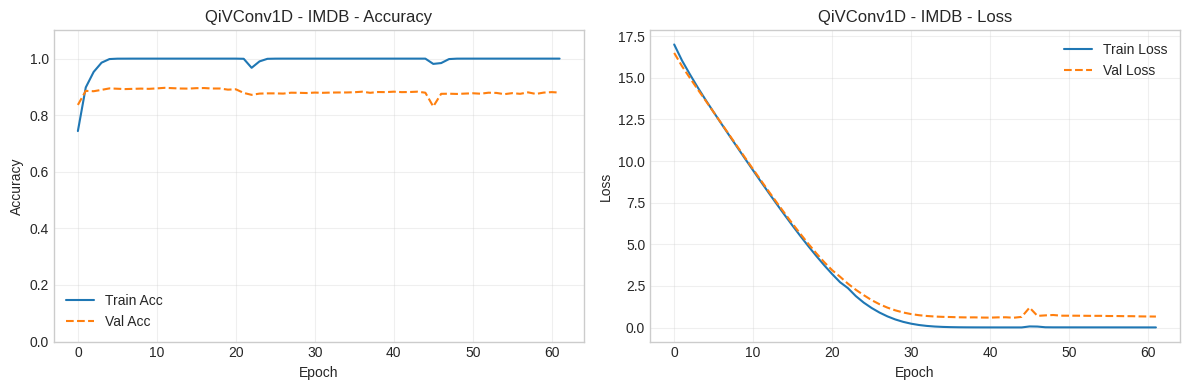

In [12]:
plot_training_curves(history_qiv, title="QiVConv1D - IMDB")

### Train a standard Conv1D baseline model on the IMDB sentiment dataset for comparison with the QiVConv1D variant.

In [13]:
# Print model training start message
print("\nTraining baseline Conv1D model on IMDB...\n")
tf.keras.backend.clear_session()  # Clear Keras session

# Initialize callback to save the best model (standard Conv1D baseline)
store_callback = StoreBestWeights(filepath='best_weights_conv1d.keras', monitor='val_accuracy', mode='max')

# --- Model Definition ---
inputs = tf.keras.Input(shape=(maxlen,)) # Input layer

# Embedding layer: maps word indices to dense vectors
x = tf.keras.layers.Embedding(max_features, 128, input_length=maxlen)(inputs)

# Standard Conv1D layer (The baseline for comparison with QiVConv1D)
x = tf.keras.layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu')(x)

# Global Max Pooling: Aggregates features across the time dimension
x = tf.keras.layers.GlobalMaxPooling1D()(x)

# Classification head (Dense layers)
x = tf.keras.layers.Dense(32, activation='relu')(x)
# Output layer: Binary classification (sentiment)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the Keras Model
model_conv = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_conv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_conv = model_conv.fit(
    x_train, y_train,
    epochs=200,
    batch_size=128,
    validation_split=0.1,
    verbose=1,
    callbacks=[store_callback] # Use the custom checkpoint/early stopping callback
)

# Load the best weights saved during training
model_conv.load_weights('best_weights_conv1d.keras')

# Evaluate the best model on the test set
loss_conv, acc_conv = model_conv.evaluate(x_test, y_test, verbose=1)

# Print final test results
print(f"\nConv1D Test Results:\n  Accuracy = {acc_conv:.4f}\n  Loss = {loss_conv:.4f}")


Training baseline Conv1D model on IMDB...

Epoch 1/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6636 - loss: 0.6125

 [Epoch 1]: val_accuracy improved from -inf to 0.8544. Saving weights.

176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6642 - loss: 0.6119 - val_accuracy: 0.8544 - val_loss: 0.3455
Epoch 2/200
165/176 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8923 - loss: 0.2633

 [Epoch 2]: val_accuracy improved from 0.8544 to 0.8828. Saving weights.

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8928 - loss: 0.2620 - val_accuracy: 0.8828 - val_loss: 0.2889
Epoch 3/200
171/176 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9586 - loss: 0.1317

 [Epoch 3]: val_accuracy improved from 0.8828 to 0.8892. Saving weights.

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9586 - loss: 0.1316 - val_accuracy: 0.8892 - val_loss: 0.2790
Epoch 4/200
173/176 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9898 - loss: 0.0529

 [Epoch 4]: val_accuracy improv

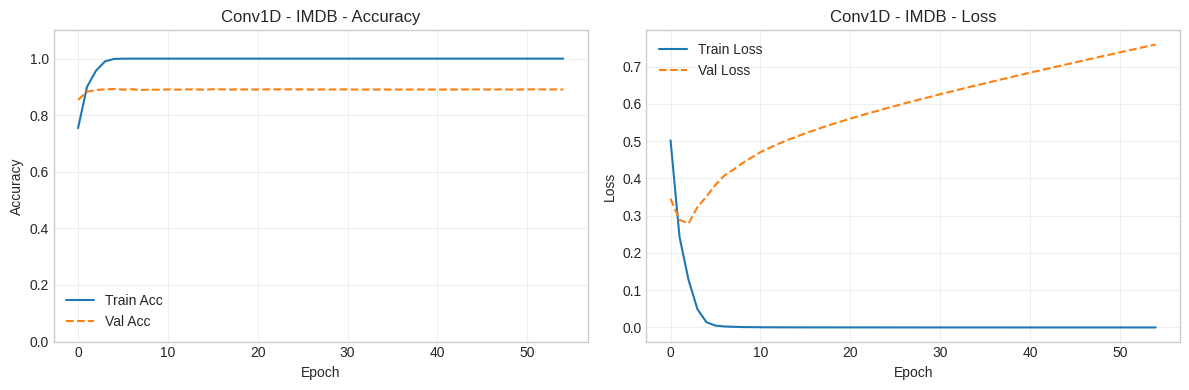

In [14]:
plot_training_curves(history_conv, title="Conv1D - IMDB")

In [15]:
print("\n" + "="*80)
print("Performance Comparison")
print("="*80)
print(f"QiVConv1D → Accuracy: {acc_qiv:.4f}, Loss: {loss_qiv:.4f}")
print(f"Conv1D    → Accuracy: {acc_conv:.4f}, Loss: {loss_conv:.4f}")
print("="*80)


Performance Comparison
QiVConv1D → Accuracy: 0.8852, Loss: 8.8431
Conv1D    → Accuracy: 0.8861, Loss: 0.3464


In [16]:
print("\n" + "="*80)
print("Experiment 2: MNIST Image Classification using QiVConv2D vs Conv2D")
print("="*80)


Experiment 2: MNIST Image Classification using QiVConv2D vs Conv2D


### Load and preprocess the MNIST handwritten digit dataset: normalize pixel values to [0, 1] and add a channel dimension for compatibility with 2D convolutional layers

In [17]:
# Load the MNIST dataset (handwritten digits)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Convert to float32, normalize pixel values to [0, 1], and add a channel dimension
# MNIST data is (samples, 28, 28). CNNs expect (samples, 28, 28, 1) for grayscale.
x_train = np.expand_dims(x_train.astype("float32") / 255.0, -1)
x_test = np.expand_dims(x_test.astype("float32") / 255.0, -1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Train a 2D image classification model using the QiVConv2D layer on the MNIST dataset as a proof-of-concept. Demonstrating the extensibility of the QiVC framework beyond 1D applications to standard vision tasks

In [18]:
# Print model training start message
print("\nTraining QiVConv2D model on MNIST...\n")
tf.keras.backend.clear_session()  # Clear Keras session

# Initialize callback to save the best model weights
store_callback = StoreBestWeights(filepath='best_weights_qiv2d.keras', monitor='val_accuracy', mode='max')

# --- Model Definition (QiVConv2D for 2D image data) ---
inputs = tf.keras.Input(shape=(28, 28, 1)) # Input shape for MNIST images (H, W, Channels)

# First QiVConv2D layer (Bayesian convolutional layer)
x = QiVConv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x) # Reduce spatial dimensions

# Second QiVConv2D layer
x = QiVConv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)

# Global Average Pooling: Flatten features for dense layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Dense layers for classification head
x = tf.keras.layers.Dense(64, activation='relu')(x)
# Output layer: 10 units with softmax for 10-class classification (MNIST digits)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create the Keras Model
model_qiv2d = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model (using sparse_categorical_crossentropy as y_train/y_test are integer labels)
model_qiv2d.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_qiv2d = model_qiv2d.fit(
    x_train, y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    verbose=1,
    callbacks=[store_callback]
)

# Load the best weights saved during training
model_qiv2d.load_weights('best_weights_qiv2d.keras')

# Evaluate the best model on the test set
loss_qiv2d, acc_qiv2d = model_qiv2d.evaluate(x_test, y_test, verbose=1)

# Print final test results
print(f"\nQiVConv2D Test Results:\n  Accuracy = {acc_qiv2d:.4f}\n  Loss = {loss_qiv2d:.4f}")


Training QiVConv2D model on MNIST...

Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2386 - loss: 9.5583

 [Epoch 1]: val_accuracy improved from -inf to 0.5452. Saving weights.

422/422 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.2389 - loss: 9.5573 - val_accuracy: 0.5452 - val_loss: 8.3433
Epoch 2/100
419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5580 - loss: 8.0715

 [Epoch 2]: val_accuracy improved from 0.5452 to 0.7063. Saving weights.

422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.5583 - loss: 8.0687 - val_accuracy: 0.7063 - val_loss: 7.1234
Epoch 3/100
421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6809 - loss: 6.9677

 [Epoch 3]: val_accuracy improved from 0.7063 to 0.7700. Saving weights.

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6809 - loss: 6.9665 - val_accuracy: 0.7700 - val_loss: 6.1597
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7476 - loss: 6.0025

 [Epoch 4]: val_accuracy improved 

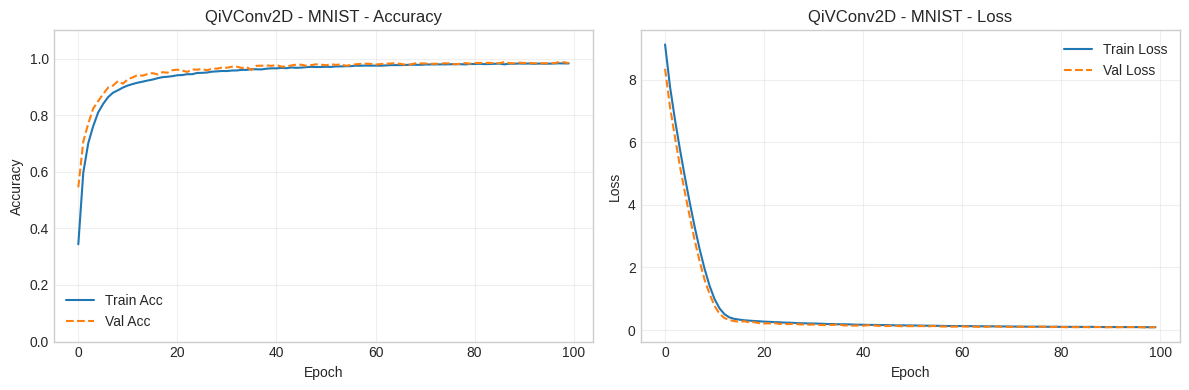

In [19]:
plot_training_curves(history_qiv2d, title="QiVConv2D - MNIST")

### Train a standard Conv2D baseline model on MNIST for comparison with the QiVConv2D variant. Providing a reference for evaluating the impact of quantum-inspired uncertainty modeling in image classification tasks

In [20]:
# Print model training start message
print("\nTraining baseline Conv2D model on MNIST...\n")
tf.keras.backend.clear_session()  # Clear Keras session

# Initialize callback to save the best model weights for the baseline
store_callback = StoreBestWeights(filepath='best_weights_conv2d.keras', monitor='val_accuracy', mode='max')

# --- Model Definition (Standard Conv2D Baseline) ---
inputs = tf.keras.Input(shape=(28, 28, 1)) # Input shape for MNIST images

# First standard Conv2D layer
x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x) # Max Pooling

# Second standard Conv2D layer
x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)

# Global Average Pooling: Flattens features
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Dense layers for classification head
x = tf.keras.layers.Dense(64, activation='relu')(x)
# Output layer: 10 units with softmax for classification
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create the Keras Model
model_conv2d = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_conv2d.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_conv2d = model_conv2d.fit(
    x_train, y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    verbose=1,
    callbacks=[store_callback] # Apply the custom callback
)

# Load the best weights saved during training
model_conv2d.load_weights('best_weights_conv2d.keras')

# Evaluate the best model on the test set
loss_conv2d, acc_conv2d = model_conv2d.evaluate(x_test, y_test, verbose=1)

# Print final test results
print(f"\nConv2D Test Results:\n  Accuracy = {acc_conv2d:.4f}\n  Loss = {loss_conv2d:.4f}")


Training baseline Conv2D model on MNIST...

Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2488 - loss: 2.0139

 [Epoch 1]: val_accuracy improved from -inf to 0.4973. Saving weights.

422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2490 - loss: 2.0133 - val_accuracy: 0.4973 - val_loss: 1.3677
Epoch 2/100
417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5531 - loss: 1.2888

 [Epoch 2]: val_accuracy improved from 0.4973 to 0.6717. Saving weights.

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5536 - loss: 1.2875 - val_accuracy: 0.6717 - val_loss: 1.0148
Epoch 3/100
421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6813 - loss: 0.9923

 [Epoch 3]: val_accuracy improved from 0.6717 to 0.7767. Saving weights.

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6814 - loss: 0.9920 - val_accuracy: 0.7767 - val_loss: 0.7526
Epoch 4/100
420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7563 - loss: 0.7850

 [Epoch 4]: val_accuracy improv

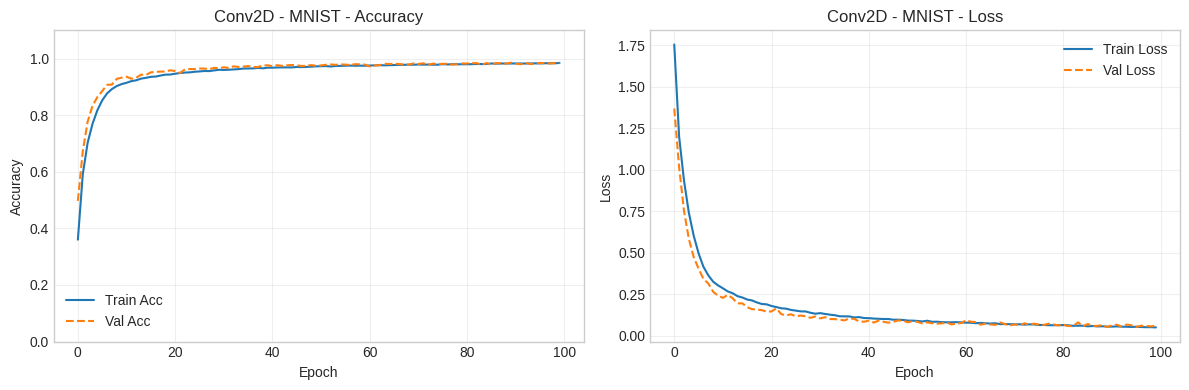

In [21]:
plot_training_curves(history_conv2d, title="Conv2D - MNIST")

In [22]:
print("\n" + "="*80)
print("Performance Comparison")
print("="*80)
print(f"QiVConv2D → Accuracy: {acc_qiv2d:.4f}, Loss: {loss_qiv2d:.4f}")
print(f"Conv2D    → Accuracy: {acc_conv2d:.4f}, Loss: {loss_conv2d:.4f}")
print("="*80)


Performance Comparison
QiVConv2D → Accuracy: 0.9814, Loss: 0.0942
Conv2D    → Accuracy: 0.9813, Loss: 0.0544


In [23]:
print("\n" + "="*120)
print("Experiment 3: IMDB Text Classification using QiVConv2D vs Conv2D Incorporating Reversal Fusion Residual Block")
print("="*120)


Experiment 3: IMDB Text Classification using QiVConv2D vs Conv2D Incorporating Reversal Fusion Residual Block


### Define a reusable model builder for IMDB sentiment classification that optionally integrates the RFR Block with QiVConv1D (when use_qivc=True) or standard Conv1D (when use_qivc=False)

In [24]:
def build_imdb_model(max_len=200, use_qivc=True):
    """
    Builds a text classification model using the Reversal Fusion Residual Block.

    Args:
        max_len (int): Maximum input sequence length.
        use_qivc (bool): Whether to use QiVConv1D inside the residual block.
    """
    inputs = tf.keras.layers.Input(shape=(max_len,)) # Input layer

    # Embedding layer: maps word indices to dense vectors
    x = tf.keras.layers.Embedding(input_dim=max_features, output_dim=128)(inputs)

    # Core feature extractor: Reversal Fusion Residual Block
    x = ReversalFusionResidualBlock(filters=64, kernel_size=7, use_qivc=use_qivc)(x)

    # Global Average Pooling: reduces sequence dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Classification head (Dense layer)
    x = tf.keras.layers.Dense(64, activation='swish')(x)

    # Output layer: single unit, sigmoid for binary classification (sentiment)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Create the Keras Model
    model = tf.keras.Model(inputs, outputs)
    return model

### Load and preprocess the IMDB movie review dataset: retain top 5,000 most frequent words and pad sequences to 200 tokens for consistent input length

In [25]:
# Constants define the size and structure of the data
max_features = 5000  # Only consider the top 5000 most frequent words
maxlen = 200         # Maximum sequence length (number of words per review)

# Load the IMDB dataset. The words are already indexed by frequency.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=max_features)

# Pad sequences to ensure all inputs have the same length (maxlen)
# Sequences shorter than maxlen are padded with zeros; longer ones are truncated.
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

### Train an IMDB sentiment classification model using the RFR block with QiVConv1D layers, demonstrating the integration of quantum-inspired uncertainty modeling into a bidirectional temporal architecture

In [26]:
tf.keras.backend.clear_session() # Clear the Keras backend session

# Build the model using the Reversal Fusion Residual Block with QiVConv (Bayesian version)
model_rfr_qivc = build_imdb_model(max_len=maxlen, use_qivc=True)

# Initialize callback to save the best weights based on validation accuracy
store_callback = StoreBestWeights(filepath='best_weights_rfr_qivc.keras', monitor='val_accuracy', mode='max')

# Compile the model with Adam optimizer and binary cross-entropy loss
model_rfr_qivc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # Use specific learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the QiVConv Reversal Fusion model
history_rfr_qivc = model_rfr_qivc.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=128,
    verbose=1,
    callbacks=[store_callback] # Apply early stopping and best weight saving
)

# Load the weights from the epoch with the best validation accuracy
model_rfr_qivc.load_weights('best_weights_rfr_qivc.keras')

# Evaluate the final model on the test set
test_loss_qivc, test_acc_qivc = model_rfr_qivc.evaluate(x_test, y_test, verbose=1)

# Print final test results
print(f"\nTest Accuracy: {test_acc_qivc:.4f}")
print(f"Test Loss: {test_loss_qivc:.4f}")

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7769 - loss: 47.0896

 [Epoch 1]: val_accuracy improved from -inf to 0.4876. Saving weights.

176/176 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.7772 - loss: 47.0863 - val_accuracy: 0.4876 - val_loss: 45.8523
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9187 - loss: 44.8507

 [Epoch 2]: val_accuracy improved from 0.4876 to 0.7436. Saving weights.

176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9187 - loss: 44.8479 - val_accuracy: 0.7436 - val_loss: 43.6238
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9481 - loss: 42.7819

 [Epoch 3]: val_accuracy improved from 0.7436 to 0.8780. Saving weights.

176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9480 - loss: 42.7792 - val_accuracy: 0.8780 - val_loss: 41.4460
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9706 - loss: 40.7286 - val_accuracy: 0.8280 - val_loss: 39.7156
Epoch 5/100
17

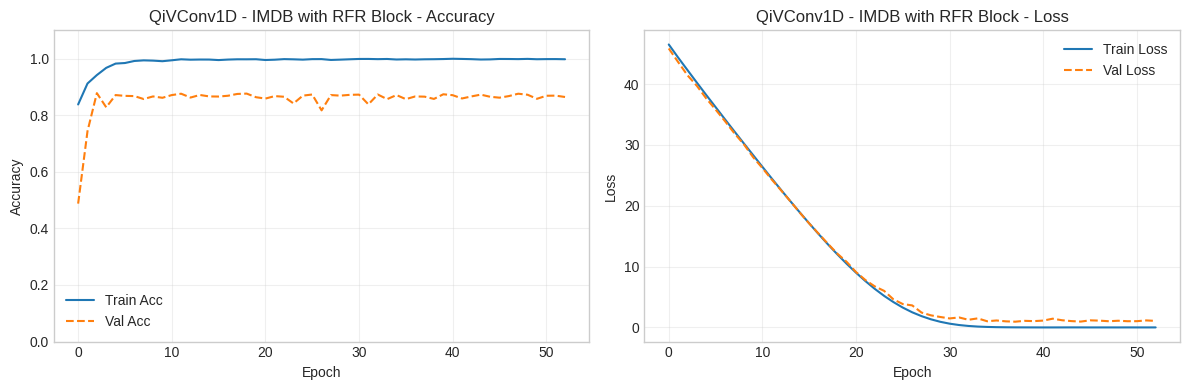

In [27]:
plot_training_curves(history_rfr_qivc, title="QiVConv1D - IMDB with RFR Block")

### Train a baseline IMDB sentiment classification model using the RFR block with standard Conv1D layers, serving as a controlled comparison to assess the added value of quantum-inspired uncertainty modeling in the RFR architecture

In [28]:
tf.keras.backend.clear_session() # Clear the Keras backend session

# Build the baseline Reversal Fusion Residual model using standard Conv1D
model_rfr_conv = build_imdb_model(max_len=maxlen, use_qivc=False)

# Initialize callback to save the best weights for the baseline model
store_callback = StoreBestWeights(filepath='best_weights_rfr_conv.keras', monitor='val_accuracy', mode='max')

# Compile the model
model_rfr_conv.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the standard Conv1D Reversal Fusion model
history_rfr_conv = model_rfr_conv.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=128,
    verbose=1,
    callbacks=[store_callback] # Apply early stopping and best weight saving
)

# Load the weights from the epoch with the best validation accuracy
model_rfr_conv.load_weights('best_weights_rfr_conv.keras')

# Evaluate the final model on the test set
test_loss_conv, test_acc_conv = model_rfr_conv.evaluate(x_test, y_test, verbose=1)

# Print final test results
print(f"\nTest Accuracy: {test_acc_conv:.4f}")
print(f"Test Loss: {test_loss_conv:.4f}")

Epoch 1/100
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7788 - loss: 0.4440

 [Epoch 1]: val_accuracy improved from -inf to 0.7328. Saving weights.

176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.7795 - loss: 0.4430 - val_accuracy: 0.7328 - val_loss: 0.6336
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9202 - loss: 0.2055

 [Epoch 2]: val_accuracy improved from 0.7328 to 0.8812. Saving weights.

176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9202 - loss: 0.2055 - val_accuracy: 0.8812 - val_loss: 0.3695
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9484 - loss: 0.1352 - val_accuracy: 0.8772 - val_loss: 0.3014
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9734 - loss: 0.0793 - val_accuracy: 0.8604 - val_loss: 0.4763
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9834 - loss: 0.0483 - val_accuracy: 0.8752 - val_loss: 0.5143
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/

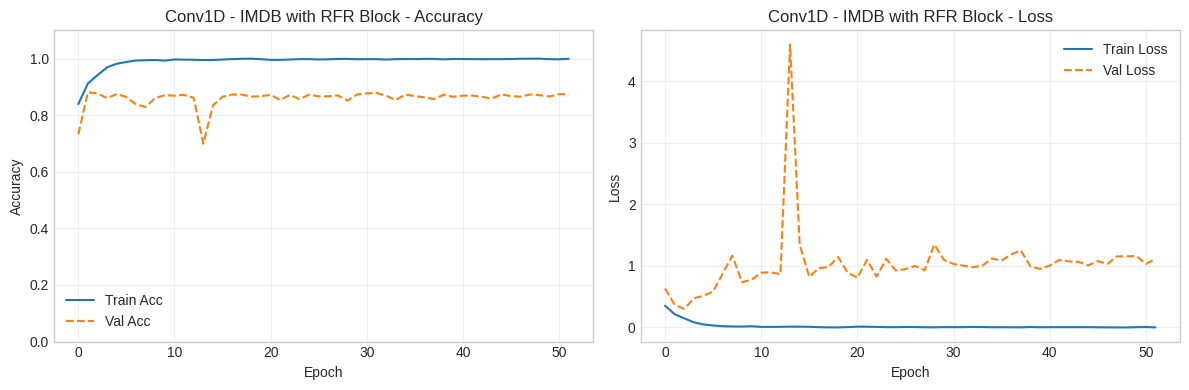

In [29]:
plot_training_curves(history_rfr_conv, title="Conv1D - IMDB with RFR Block")

In [30]:
print("\n" + "="*80)
print("Performance Comparison, Using IMDB incorporating RFR Block")
print("="*80)
print(f"QiVConv2D → Accuracy: {test_acc_qivc:.4f}, Loss: {test_loss_qivc:.4f}")
print(f"Conv2D    → Accuracy: {test_acc_conv:.4f}, Loss: {test_loss_conv:.4f}")
print("="*80)


Performance Comparison, Using IMDB incorporating RFR Block
QiVConv2D → Accuracy: 0.8694, Loss: 41.4483
Conv2D    → Accuracy: 0.8708, Loss: 0.3772


### Load and preprocess the PathMNIST dataset (a MedMNIST benchmark for histopathology image classification): normalize pixel values to [0, 1] and retain original image and label arrays for use with custom models
https://medmnist.com/

In [31]:
# Define which dataset to load
data_flag = 'pathmnist' # PathMNIST: Colon Pathology multi-class image dataset
info = INFO[data_flag]              # Retrieve metadata (e.g., class name, task)
DataClass = getattr(medmnist.dataset, info['python_class']) # Get the corresponding Python class (e.g., PathMNIST)

# Preprocess: load data from the MedMNIST class
# Load training and test images (imgs) and labels (labels)
x_train, y_train = DataClass(split='train', download=True).imgs, DataClass(split='train', download=True).labels
x_test, y_test = DataClass(split='test', download=True).imgs, DataClass(split='test', download=True).labels

# Normalize images: convert to float32 and scale pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Print confirmation and data dimensions
print(f"PathMNIST Data Loaded and Preprocessed:")
print(f"x_train shape: {x_train.shape}") # Should be (samples, 28, 28, 3) for PathMNIST
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

100%|██████████| 206M/206M [00:37<00:00, 5.45MB/s]


PathMNIST Data Loaded and Preprocessed:
x_train shape: (89996, 28, 28, 3)
y_train shape: (89996, 1)
x_test shape: (7180, 28, 28, 3)
y_test shape: (7180, 1)


### Train a histopathology image classification model using QiVConv2D on the PathMNIST dataset (a MedMNIST benchmark for tissue-type recognition) demonstrating the applicability of quantum-inspired uncertainty-aware convolutions to biomedical image analysis tasks

In [32]:
tf.keras.backend.clear_session() # Clear the Keras backend session

# Initialize callback to save the best model weights for QiVConv2D on PathMNIST
store_callback = StoreBestWeights(filepath='best_weights_qiv2d_pathmnist.keras', monitor='val_accuracy', mode='max')

# Determine number of classes and input shape from previously loaded data
num_classes = len(info['label']) # Number of output classes for PathMNIST
input_shape = x_train.shape[1:]  # Input shape (H, W, Channels)

# --- Model Definition ---
inputs = tf.keras.Input(shape=input_shape) # Input layer with PathMNIST shape

# First QiVConv2D layer (Bayesian convolution)
x = QiVConv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x) # Max Pooling

# Second QiVConv2D layer
x = QiVConv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)

# Global Average Pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Dense layers for classification head
x = tf.keras.layers.Dense(64, activation='relu')(x)
# Output layer: 'num_classes' units with softmax for multi-class classification
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the Keras Model
model_qiv2d_pathmnist = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_qiv2d_pathmnist.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the QiVConv2D model on PathMNIST
history_qiv2d_pathmnist = model_qiv2d_pathmnist.fit(
    x_train, y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    verbose=1,
    callbacks=[store_callback]
)

# Load the best weights
model_qiv2d_pathmnist.load_weights('best_weights_qiv2d_pathmnist.keras')

# Evaluate the best model on the test set
loss_qiv2d_pathmnist, acc_qiv2d_pathmnist = model_qiv2d_pathmnist.evaluate(x_test, y_test, verbose=1)

# Print final test results
print(f"\nQiVConv2D PathMNIST Test Results:\n  Accuracy = {acc_qiv2d_pathmnist:.4f}\n  Loss = {loss_qiv2d_pathmnist:.4f}")

Epoch 1/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3322 - loss: 9.4770

 [Epoch 1]: val_accuracy improved from -inf to 0.5731. Saving weights.

633/633 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.3324 - loss: 9.4761 - val_accuracy: 0.5731 - val_loss: 7.8880
Epoch 2/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5871 - loss: 7.5649

 [Epoch 2]: val_accuracy improved from 0.5731 to 0.6377. Saving weights.

633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5871 - loss: 7.5643 - val_accuracy: 0.6377 - val_loss: 6.5967
Epoch 3/100
632/633 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6394 - loss: 6.2765

 [Epoch 3]: val_accuracy improved from 0.6377 to 0.6522. Saving weights.

633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6394 - loss: 6.2755 - val_accuracy: 0.6522 - val_loss: 5.3655
Epoch 4/100
625/633 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6621 - loss: 5.0791

 [Epoch 4]: val_accuracy improved from 0.6522 to 0.6760. Saving weights.



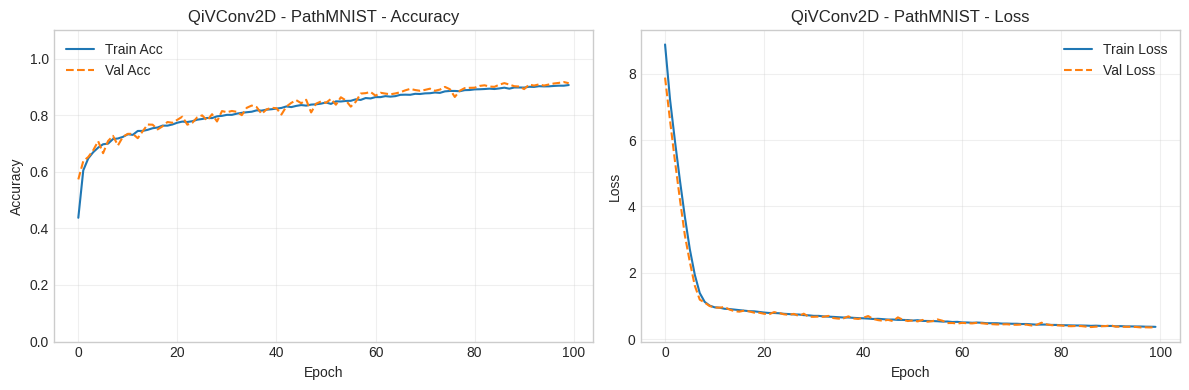

In [33]:
plot_training_curves(history_qiv2d_pathmnist, title="QiVConv2D - PathMNIST")

### Train a standard Conv2D baseline model on the PathMNIST histopathology dataset for comparison with the quantum-inspired QiVConv2D variant. Providing a reference to evaluate the impact of structured uncertainty modeling in biomedical image classification

In [34]:
tf.keras.backend.clear_session() # Clear the Keras backend session

# Initialize callback to save the best model weights for the Conv2D baseline
store_callback = StoreBestWeights(filepath='best_weights_conv2d_pathmnist.keras', monitor='val_accuracy', mode='max')

# Determine number of classes and input shape from previously loaded data
num_classes = len(info['label']) # Number of output classes
input_shape = x_train.shape[1:]  # Input shape (H, W, Channels)

# --- Model Definition (Standard Conv2D Baseline) ---
inputs = tf.keras.Input(shape=input_shape) # Input layer

# First standard Conv2D layer
x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x) # Max Pooling

# Second standard Conv2D layer
x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)

# Global Average Pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Dense layers for classification head
x = tf.keras.layers.Dense(64, activation='relu')(x)
# Output layer: 'num_classes' units with softmax
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the Keras Model
model_conv2d_pathmnist = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_conv2d_pathmnist.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the baseline Conv2D model on PathMNIST
history_conv2d_pathmnist = model_conv2d_pathmnist.fit(
    x_train, y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    verbose=1,
    callbacks=[store_callback]
)

# Load the best weights
model_conv2d_pathmnist.load_weights('best_weights_conv2d_pathmnist.keras')

# Evaluate the best model on the test set
loss_conv2d_pathmnist, acc_conv2d_pathmnist = model_conv2d_pathmnist.evaluate(x_test, y_test, verbose=1)

# Print final test results
print(f"\nConv2D PathMNIST Test Results:\n  Accuracy = {acc_conv2d_pathmnist:.4f}\n  Loss = {loss_conv2d_pathmnist:.4f}")

Epoch 1/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3474 - loss: 1.7478

 [Epoch 1]: val_accuracy improved from -inf to 0.5700. Saving weights.

633/633 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3476 - loss: 1.7474 - val_accuracy: 0.5700 - val_loss: 1.1586
Epoch 2/100
629/633 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5828 - loss: 1.1268

 [Epoch 2]: val_accuracy improved from 0.5700 to 0.6048. Saving weights.

633/633 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5829 - loss: 1.1264 - val_accuracy: 0.6048 - val_loss: 1.0833
Epoch 3/100
632/633 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6479 - loss: 0.9663

 [Epoch 3]: val_accuracy improved from 0.6048 to 0.6813. Saving weights.

633/633 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6480 - loss: 0.9662 - val_accuracy: 0.6813 - val_loss: 0.8620
Epoch 4/100
623/633 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6895 - loss: 0.8560

 [Epoch 4]: val_accuracy improved from 0.6813 to 0.7056. Saving weights.

63

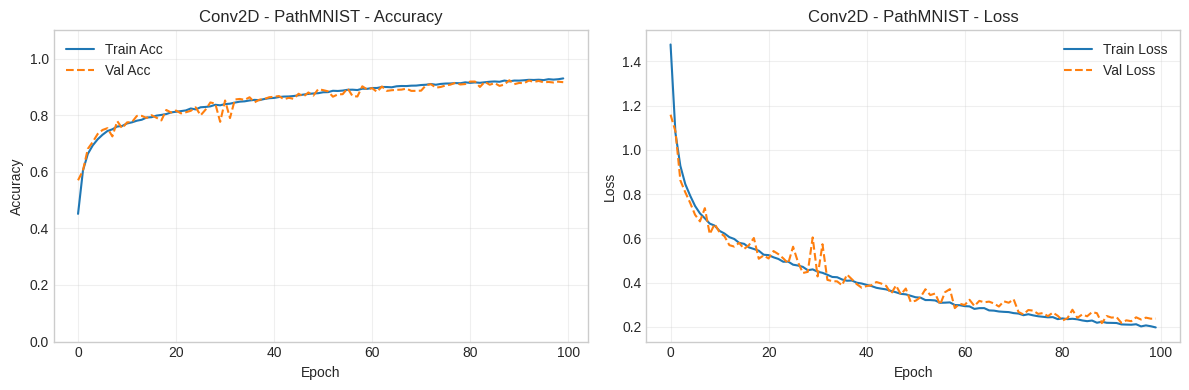

In [35]:
plot_training_curves(history_conv2d_pathmnist, title="Conv2D - PathMNIST")

In [36]:
print("\n" + "="*80)
print("Performance Comparison on PathMNIST")
print("="*80)
print(f"QiVConv2D -> Accuracy: {acc_qiv2d_pathmnist:.4f}, Loss: {loss_qiv2d_pathmnist:.4f}")
print(f"Conv2D    -> Accuracy: {acc_conv2d_pathmnist:.4f}, Loss: {loss_conv2d_pathmnist:.4f}")
print("="*80)


Performance Comparison on PathMNIST
QiVConv2D -> Accuracy: 0.8398, Loss: 0.7109
Conv2D    -> Accuracy: 0.8228, Loss: 1.0166
